In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

print("Libraries imported")

Libraries imported


In [2]:
# Google Colab drive mount - NOT NEEDED for local execution
# If you have MNIST data in a local folder, update the paths in the next cell
print("Running locally - Google Drive not mounted")

Running locally - Google Drive not mounted


In [4]:
# loading the training and test data from local dataset folder
try:
  train_df = pd.read_csv("../dataset/mnist_train.csv")
  test_df = pd.read_csv("../dataset/mnist_test.csv")
  print("Training and testing data loaded successfully!\n")

  # Check for NaN values and drop rows containing them
  initial_train_rows = train_df.shape[0]
  initial_test_rows = test_df.shape[0]
  train_df.dropna(inplace=True)
  test_df.dropna(inplace=True)
  print(f"Removed {initial_train_rows - train_df.shape[0]} rows with NaN values from training data.")
  print(f"Removed {initial_test_rows - test_df.shape[0]} rows with NaN values from testing data.")

  # viewing the first few rows of the training data
  print(train_df.head())
except Exception as e:
  print(f"Failed to load data: {e}")
  print("Make sure mnist_train.csv and mnist_test.csv are in the dataset folder")

Training and testing data loaded successfully!

Removed 0 rows with NaN values from training data.
Removed 0 rows with NaN values from testing data.
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
Removed 0 

In [5]:
# separating the features and the label
x_train = train_df.drop(train_df.columns[0], axis = 1)
y_train = train_df[train_df.columns[0]]

x_test = test_df.drop(test_df.columns[0], axis=1)
y_test = test_df[test_df.columns[0]]

# check features
print(f"Training features shape: {x_train.shape}")
print(f"Labels count: {y_train.shape}")
print(f"Training features shape: {x_test.shape}")
print(f"Labels count: {y_test.shape}")

Training features shape: (60000, 784)
Labels count: (60000,)
Training features shape: (10000, 784)
Labels count: (10000,)


In [6]:
# normalizing the pixels
x_train_normalized = x_train.values / 255.0
x_test_nomalized = x_test.values / 255.0

print("Data normalized")

# check new min and max values
print(f"Original max value: {x_train.values.max()}")
print(f"Normalized max value: {x_train_normalized.max()}")

Data normalized
Original max value: 255
Normalized max value: 1.0


Original shape: (60000, 784)
New shape: (60000, 28, 28, 1)


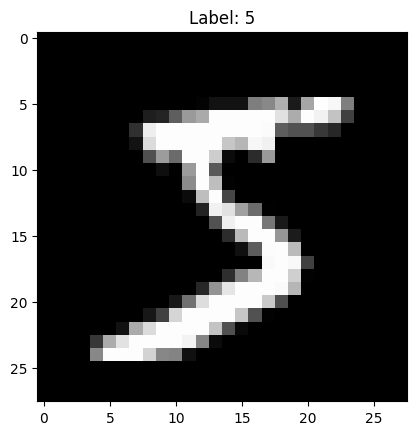

In [7]:
# reshaping the data to be 28x28 images since features = 784
# converting into grayscale images (-1, 28, 28, 1) (numImages, height, width, color channels)
x_train_reshape = x_train_normalized.reshape(-1, 28, 28, 1)
x_test_reshape = x_test_nomalized.reshape(-1, 28, 28, 1)

print(f"Original shape: {x_train_normalized.shape}")
print(f"New shape: {x_train_reshape.shape}")

# viewing one instance for checking
plt.imshow(x_train_reshape[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

In [8]:
from keras.utils import to_categorical

# converting the training and testing data to one-hot encoded vectors
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Labels converted successfully!")

# checking the changes
print(f"\nOriginal label: {y_train[0]}")
print(f"\nCategorical label: {y_train_cat[0]}")

Labels converted successfully!

Original label: 5

Categorical label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
from sklearn.model_selection import train_test_split

# splitting 80-20 train/test
X_train, X_val, Y_train, Y_val = train_test_split(
    x_train_reshape,
    y_train_cat,
    test_size = 0.2,
    random_state = 42
)

print(f"Original training images: {x_train_reshape.shape[0]}")
print(f"New training images: {X_train.shape[0]}")
print(f"New testing images: {X_val.shape[0]}")

Original training images: 60000
New training images: 48000
New testing images: 12000


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# defining the image data generator
train_datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate images by up to 10 degrees
    zoom_range=0.1,         # randomly zoom in by up to 10%
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1  # randomly shift images vertically by 10%
)

# fitting the generator to our training data
train_datagen.fit(X_train)

print("ImageDataGenerator set up!")

ImageDataGenerator set up!


In [11]:
# --- Model 1: Baseline (1 Dense Layer CNN [Shallow NN]) ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

print("\n--- Baseline Model Summary ---")
baseline_model.summary()


--- Baseline Model Summary ---


C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Model 2: Deep Neural Network (4 Dense layers with ReLU, Dropout) ---

dnn_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28,1)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

print("\n--- DNN Model Summary ---")
dnn_model.summary()


--- DNN Model Summary ---


C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# creating pre-trained CNN of your choice (ResNet-50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

In [13]:
# --- Model 3: Pre-trained CNN (MobileNetV2) ---

from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Lambda
from keras.models import Model

input_tensor = Input(shape=(28, 28, 1))

# Wrap tf.repeat in a Lambda layer
x = layers.Lambda(lambda image: tf.image.resize(image, (32, 32)))(input_tensor)
x_rgb = layers.Lambda(lambda image: tf.image.grayscale_to_rgb(image))(x)

mobilenet_model = MobileNetV2(
    input_tensor=x_rgb,
    weights='imagenet',
    include_top=False,
)

mobilenet_model.trainable = False

x_mobilenet = GlobalAveragePooling2D()(mobilenet_model.output)
x_mobilenet = Dense(128, activation='relu')(x_mobilenet)
output_tensor = Dense(10, activation='softmax')(x_mobilenet)

mobilenetv2_model = Model(inputs=input_tensor, outputs=output_tensor)
print("\n--- Pre-trained MobileNetV2 Model Summary ---")
mobilenetv2_model.summary()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_57156\1742407081.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Pre-trained MobileNetV2 Model Summary ---

--- Pre-trained MobileNetV2 Model Summary ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32, 1) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32, 32, 3) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# --- Model 3: Pre-trained CNN (ResNet50) ---
base_resnet50 = ResNet50(
    input_tensor=x_rgb,
    weights='imagenet',
    include_top=False
)
base_resnet50.trainable = False

# Add custom classifier
x_resnet50 = GlobalAveragePooling2D()(base_resnet50.output)
x_resnet50 = Dense(128, activation='relu')(x_resnet50)
output_resnet50 = Dense(10, activation='softmax')(x_resnet50)

resnet50_model = Model(inputs=input_tensor, outputs=output_resnet50)
print("\n--- Pre-trained ResNet50 Model Summary ---")
resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

--- Pre-trained ResNet50 Model Summary ---

--- Pre-trained ResNet50 Model Summary ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32, 1) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32, 32, 3) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ lambda_1[0][0]    │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
from tensorflow.keras.metrics import RootMeanSquaredError

# --- 1. Compile Baseline Model ---
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', RootMeanSquaredError(name='rmse')]
)

# --- 2. Compile DNN Model ---
dnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', RootMeanSquaredError(name='rmse')]
)


# --- 3. Compile Resnet50 Model ---
resnet50_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', RootMeanSquaredError(name='rmse')]
)

# --- 4. Compile Mobile Net V2 Model ---
mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', RootMeanSquaredError(name='rmse')]
)

print("All models are compiled and ready to train!")

All models are compiled and ready to train!


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

print("--- Training Parameters ---")
epochs = 300
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# logs of each training run
all_history = {}

--- Training Parameters ---


In [17]:
# Train and evaluate for baseline model (1 Dense Layer CNN [Shallow NN])

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)

print("--- Training Baseline CNN Model ---")
history_baseline = baseline_model.fit(train_generator, epochs=300, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
print("Stopped")
print("Evaluating Baseline Model on the Test Set...")
baseline_eval = baseline_model.evaluate(x_test_reshape, y_test_cat)

all_history['baseline'] = history_baseline

--- Training Baseline CNN Model ---
Epoch 1/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7960 - loss: 0.6763 - rmse: 0.1731 - val_accuracy: 0.9553 - val_loss: 0.1803 - val_rmse: 0.0876
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7960 - loss: 0.6763 - rmse: 0.1731 - val_accuracy: 0.9553 - val_loss: 0.1803 - val_rmse: 0.0876
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9115 - loss: 0.3014 - rmse: 0.1169 - val_accuracy: 0.9628 - val_loss: 0.1399 - val_rmse: 0.0778
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9115 - loss: 0.3014 - rmse: 0.1169 - val_accuracy: 0.9628 - val_loss: 0.1399 - val_rmse: 0.0778
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9225 - loss: 0.2595 - rmse: 0.1086 - val_accuracy: 0.9676 - val_loss: 0.1161 - val_rmse: 0.0718
Epoch 4/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9225 - loss: 0.2595 - rmse: 0.1086 - val_accuracy: 0.9676 - val_loss: 

In [18]:
# Train and evaluate for deep neural network (4 Dense layers with ReLU, Dropout)

print("--- Training Deep Neural Network Model ---")

history_dnn = dnn_model.fit(train_generator, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)

print("Stopped")
print("Evaluating DNN Model on the Test Set")
dnn_eval = dnn_model.evaluate(x_test_reshape, y_test_cat)

all_history['dnn'] = history_dnn

--- Training Deep Neural Network Model ---
Epoch 1/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7103 - loss: 0.8965 - rmse: 0.1982 - val_accuracy: 0.9504 - val_loss: 0.1806 - val_rmse: 0.0894
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7103 - loss: 0.8965 - rmse: 0.1982 - val_accuracy: 0.9504 - val_loss: 0.1806 - val_rmse: 0.0894
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8823 - loss: 0.4084 - rmse: 0.1343 - val_accuracy: 0.9528 - val_loss: 0.1542 - val_rmse: 0.0843
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8823 - loss: 0.4084 - rmse: 0.1343 - val_accuracy: 0.9528 - val_loss: 0.1542 - val_rmse: 0.0843
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9078 - loss: 0.3234 - rmse: 0.1192 - val_accuracy: 0.9597 - val_loss: 0.1429 - val_rmse: 0.0799
Epoch 4/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9078 - loss: 0.3234 - rmse: 0.1192 - val_accuracy: 0.9597 - val

In [19]:
# Train and evaluate for pre-trained CNN of your choice (MobileNetV2)

print("\n--- Training Pre-trained MobileNetV2 Model ---")
history_mobilenet = mobilenetv2_model.fit(train_generator, epochs=epochs, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[early_stopping], verbose=1)
print("Evaluating Pre-trained Model on the Test Set...")
mobilenet_eval = mobilenetv2_model.evaluate(x_test_reshape, y_test_cat)


--- Training Pre-trained MobileNetV2 Model ---
Epoch 1/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - accuracy: 0.5313 - loss: 1.3816 - rmse: 0.2485 - val_accuracy: 0.6349 - val_loss: 1.0816 - val_rmse: 0.2249
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - accuracy: 0.5313 - loss: 1.3816 - rmse: 0.2485 - val_accuracy: 0.6349 - val_loss: 1.0816 - val_rmse: 0.2249
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.5928 - loss: 1.1696 - rmse: 0.2327 - val_accuracy: 0.6547 - val_loss: 1.0212 - val_rmse: 0.2188
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.5928 - loss: 1.1696 - rmse: 0.2327 - val_accuracy: 0.6547 - val_loss: 1.0212 - val_rmse: 0.2188
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.6076 - loss: 1.1335 - rmse: 0.2292 - val_accuracy: 0.6640 - val_loss: 0.9942 - val_rmse: 0.2167
Epoch 4/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.6076 - loss: 1.1335 - rmse: 0.2292 - val_accuracy: 0.6640 

In [20]:
# Train and evaluate for pre-trained CNN of your choice (ResNet-50)

print("--- ResNet-50 Model ---")

history_resnet50 = resnet50_model.fit(train_generator, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
print("Evaluating Pre-trained Model on the Test Set")
resnet50_eval = resnet50_model.evaluate(x_test_reshape, y_test_cat)

all_history['resnet50'] = history_resnet50

--- ResNet-50 Model ---
Epoch 1/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 186s 241ms/step - accuracy: 0.6664 - loss: 1.0339 - rmse: 0.2145 - val_accuracy: 0.7669 - val_loss: 0.7079 - val_rmse: 0.1823
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 186s 241ms/step - accuracy: 0.6664 - loss: 1.0339 - rmse: 0.2145 - val_accuracy: 0.7669 - val_loss: 0.7079 - val_rmse: 0.1823
Epoch 2/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.7844 - loss: 0.6645 - rmse: 0.1758 - val_accuracy: 0.8074 - val_loss: 0.5813 - val_rmse: 0.1671
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.7844 - loss: 0.6645 - rmse: 0.1758 - val_accuracy: 0.8074 - val_loss: 0.5813 - val_rmse: 0.1671
Epoch 3/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 199s 265ms/step - accuracy: 0.8129 - loss: 0.5777 - rmse: 0.1642 - val_accuracy: 0.8590 - val_loss: 0.4445 - val_rmse: 0.1438
Epoch 4/300
750/750 ━━━━━━━━━━━━━━━━━━━━ 199s 265ms/step - accuracy: 0.8129 - loss: 0.5777 - rmse: 0.1642 - val_accuracy: 0.8590 - val_loss: 


Step 5: Generating Outputs for Analysis...

--- Final Model Performance on Test Set ---
Baseline Model      - Accuracy: 0.9817, RMSE: 0.0549
DNN Model           - Accuracy: 0.9491, RMSE: 0.0887
ResNet50 Model      - Accuracy: 0.7801, RMSE: 0.1775


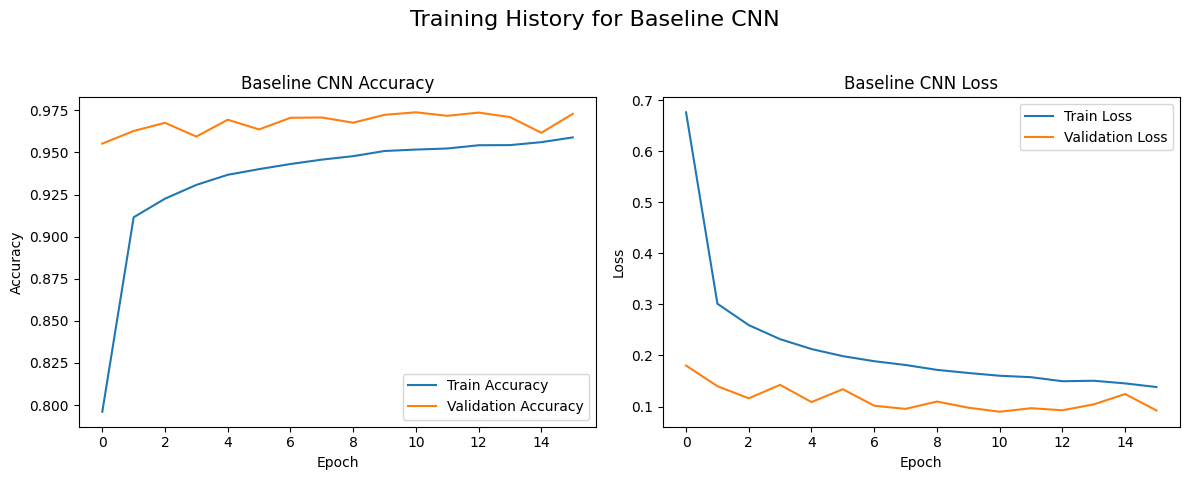

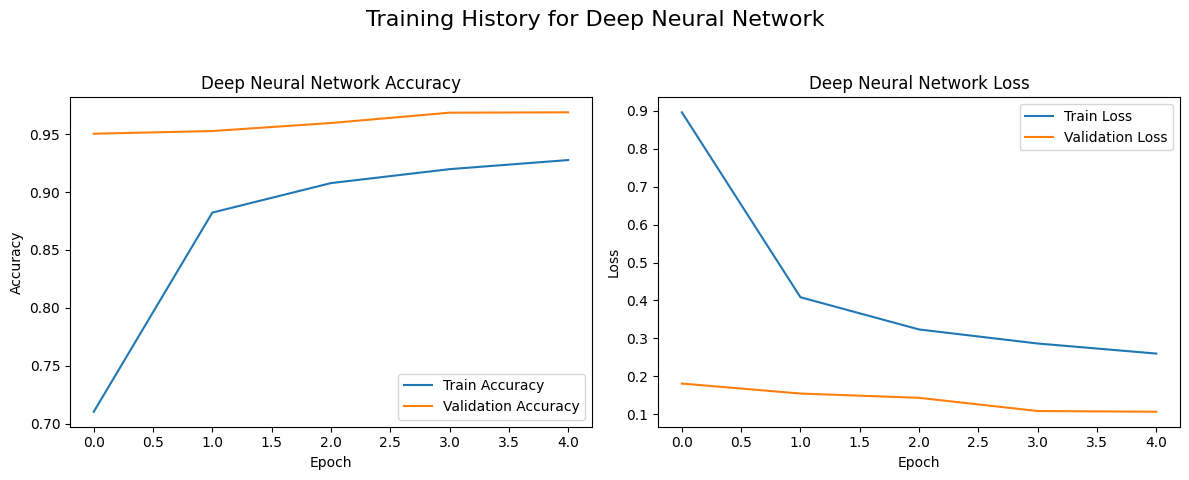

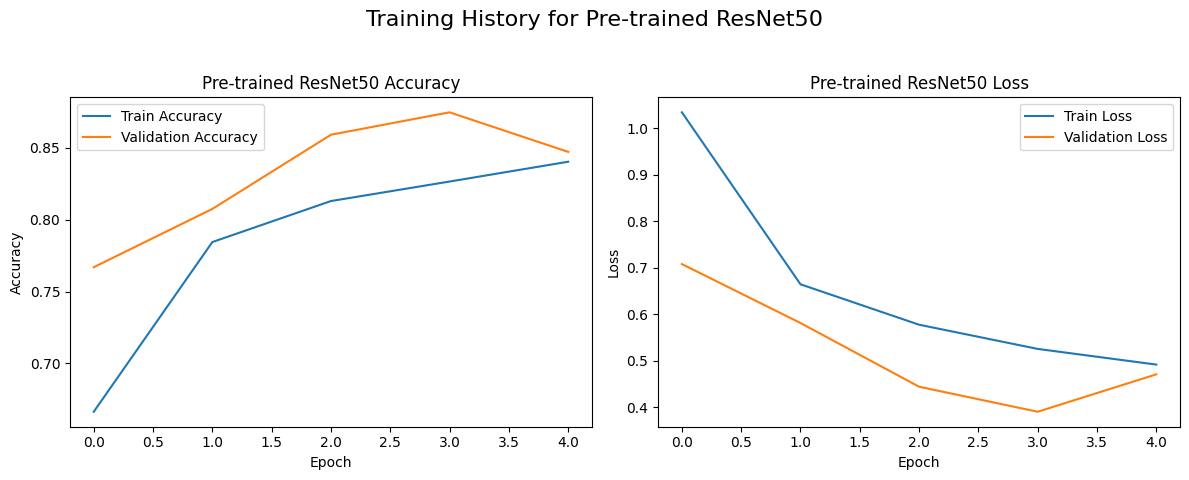

In [21]:

# =============================================================================
# STEP 5: OBSERVATION AND ANALYSIS (Generate Outputs)
# =============================================================================
print("\nStep 5: Generating Outputs for Analysis...")

# --- 1. Final Performance Summary ---
print("\n--- Final Model Performance on Test Set ---")
print(f"Baseline Model      - Accuracy: {baseline_eval[1]:.4f}, RMSE: {baseline_eval[2]:.4f}")
print(f"DNN Model           - Accuracy: {dnn_eval[1]:.4f}, RMSE: {dnn_eval[2]:.4f}")
print(f"ResNet50 Model      - Accuracy: {resnet50_eval[1]:.4f}, RMSE: {resnet50_eval[2]:.4f}")

# --- 2. Training History Plots ---
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.suptitle(f'Training History for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_history(history_baseline, "Baseline CNN")
plot_history(history_dnn, "Deep Neural Network")
plot_history(history_resnet50, "Pre-trained ResNet50")


In [23]:

# --- 3. Predicted vs. Actual Plots (Confusion Matrix) ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, model_name):
    y_pred_probs = model.predict(x_test_reshape)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Predicted vs. Actual - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



Generating Predicted vs. Actual plots (Confusion Matrices)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


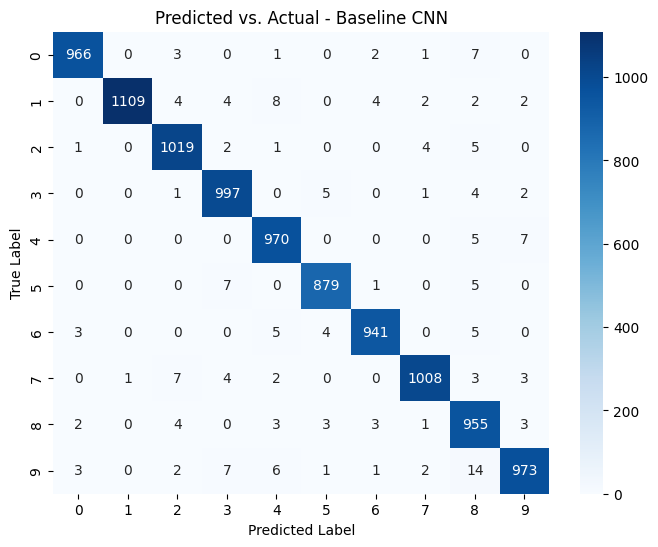

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


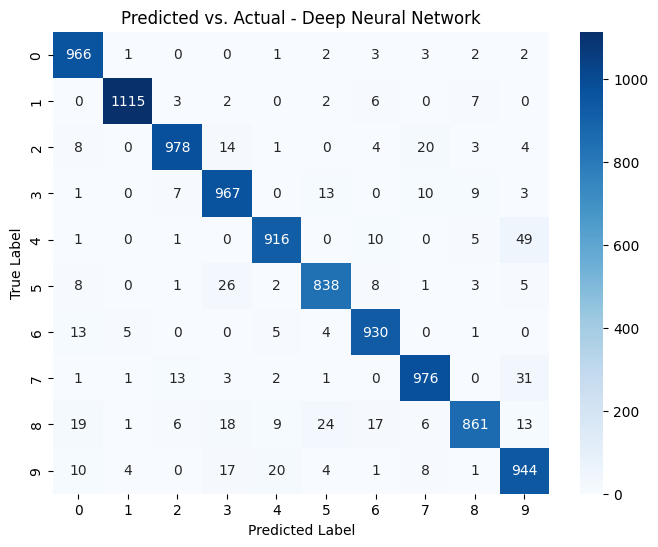

313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step


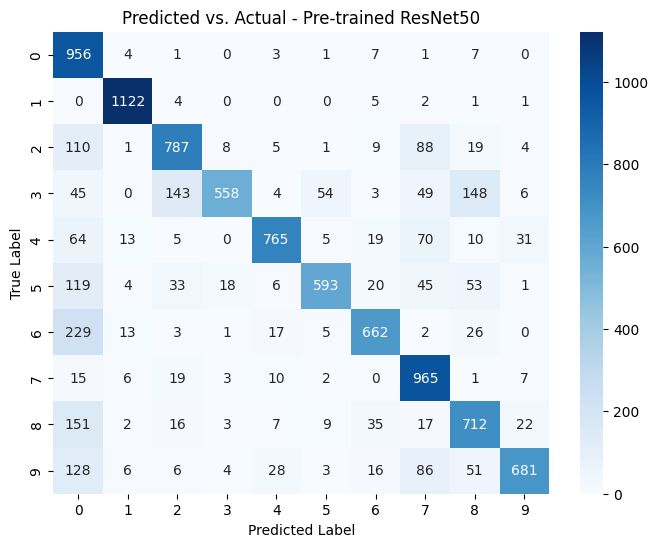

In [24]:

print("\nGenerating Predicted vs. Actual plots (Confusion Matrices)...")
plot_confusion_matrix(baseline_model, "Baseline CNN")
plot_confusion_matrix(dnn_model, "Deep Neural Network")
plot_confusion_matrix(resnet50_model, "Pre-trained ResNet50")

In [25]:

# =============================================================================
# STEP 6: EXPORT BEST MODEL FOR DEPLOYMENT
# =============================================================================
print("\n" + "="*80)
print("STEP 6: EXPORTING BEST MODEL FOR WEB DEPLOYMENT")
print("="*80)

import json

# Based on test accuracy, Baseline CNN is the best model (98.17%)
best_model = baseline_model
best_model_name = "Baseline CNN"
best_accuracy = 0.9817

print(f"\n✓ Best Model: {best_model_name}")
print(f"✓ Test Accuracy: {best_accuracy*100:.2f}%")

# Save model
model_filename = "mnist_classifier.keras"
best_model.save(model_filename)
print(f"✓ Model saved: {model_filename}")

# Save class labels
labels_filename = "class_labels.json"
class_labels = [str(i) for i in range(10)]
with open(labels_filename, 'w') as f:
    json.dump(class_labels, f)
print(f"✓ Labels saved: {labels_filename}")

# Verify files
import os
if os.path.exists(model_filename) and os.path.exists(labels_filename):
    model_size = os.path.getsize(model_filename) / (1024 * 1024)
    print(f"\n{'='*80}")
    print("✓ EXPORT SUCCESSFUL!")
    print(f"{'='*80}")
    print(f"Model file size: {model_size:.2f} MB")
    print(f"Ready for web deployment with Streamlit!")
    print(f"\nNext step: streamlit run app.py")
    print(f"{'='*80}")
else:
    print("✗ Error: Files were not created")



STEP 6: EXPORTING BEST MODEL FOR WEB DEPLOYMENT

✓ Best Model: Baseline CNN
✓ Test Accuracy: 98.17%
✓ Model saved: mnist_classifier.keras
✓ Labels saved: class_labels.json

✓ EXPORT SUCCESSFUL!
Model file size: 0.65 MB
Ready for web deployment with Streamlit!

Next step: streamlit run app.py


In [26]:
print("=" * 80)
print("STEP 7: EXPORTING ALL 4 MODELS")
print("=" * 80)

models_to_export = {
    "baseline_cnn.keras": baseline_model,
    "dnn_dropout.keras": dnn_model,
    "mobilenetv2_transfer.keras": mobilenetv2_model,
    "resnet50_transfer.keras": resnet50_model
}

model_accuracies = {
    "Baseline CNN": baseline_eval[1],
    "DNN with Dropout": dnn_eval[1],
    "MobileNetV2 Transfer": mobilenet_eval[1],
    "ResNet50 Transfer": resnet50_eval[1]
}

print("\nExporting all trained models...\n")

for filename, model in models_to_export.items():
    try:
        model.save(filename)
        file_size = os.path.getsize(filename) / (1024 * 1024)
        print(f"✓ Saved: {filename} ({file_size:.2f} MB)")
    except Exception as e:
        print(f"❌ Error saving {filename}: {e}")

print("\nModel Performance Summary:")
print("-" * 80)
for model_name, accuracy in model_accuracies.items():
    print(f"  {model_name:.<40} {accuracy*100:.2f}%")

print("\n" + "=" * 80)
print("✓ ALL MODELS EXPORTED SUCCESSFULLY!")
print("=" * 80)
print("\nFiles created:")
print(f"  1. baseline_cnn.keras")
print(f"  2. dnn_dropout.keras")
print(f"  3. mobilenetv2_transfer.keras")
print(f"  4. resnet50_transfer.keras")
print(f"  5. class_labels.json (already exists)")
print("\nYou can now:")
print("  - Use any model with app.py by changing model_path")
print("  - Create different web apps for each model")
print("  - Compare model performance")
print("=" * 80)

STEP 7: EXPORTING ALL 4 MODELS

Exporting all trained models...

✓ Saved: baseline_cnn.keras (0.65 MB)
✓ Saved: dnn_dropout.keras (2.84 MB)
✓ Saved: dnn_dropout.keras (2.84 MB)
✓ Saved: mobilenetv2_transfer.keras (11.07 MB)
✓ Saved: mobilenetv2_transfer.keras (11.07 MB)
✓ Saved: resnet50_transfer.keras (93.63 MB)

Model Performance Summary:
--------------------------------------------------------------------------------
  Baseline CNN............................ 98.17%
  DNN with Dropout........................ 94.91%
  MobileNetV2 Transfer.................... 63.17%
  ResNet50 Transfer....................... 78.01%

✓ ALL MODELS EXPORTED SUCCESSFULLY!

Files created:
  1. baseline_cnn.keras
  2. dnn_dropout.keras
  3. mobilenetv2_transfer.keras
  4. resnet50_transfer.keras
  5. class_labels.json (already exists)

You can now:
  - Use any model with app.py by changing model_path
  - Create different web apps for each model
  - Compare model performance
✓ Saved: resnet50_transfer.keras 